Extracted from: https://www.kaggle.com/code/eriknovak/pytorch-roberta-named-entity-recognition

# Named Entity Recognition using RoBERTa

In this notebook we will train a Named Entity Recognition (NER) model using RoBERTa.

The python libraries that we will use in this notebook are:

- [transformers][transformers]. The huggingface library containing the general-purpose architectures for NLP.
- [datasets][datasets]. The huggingface library containing datasets and evaluation metrics for NLP.
- [torch][torch]. An open source machine learning framework used to create and train models on the GPU.
- [matplotlib][matplotlib]. A comprehensive library for creating static, animated and interactive visualizations in Python.

[transformers]: https://huggingface.co/transformers/index.html
[datasets]: https://huggingface.co/docs/datasets/
[torch]: https://pytorch.org/
[matplotlib]: https://matplotlib.org/

**NOTE:** The notebook uses `transformers-3.5.1` and `torch-1.7.0` versions.

# Import the Libraries

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"  # Workaround for M1 GPUs
# Previous code must be executed before importing torch


# visualization libraries
import matplotlib.pyplot as plt
import numpy as np

# pytorch libraries
import torch # the main pytorch library
import torch.nn as nn # the sub-library containing Softmax, Module and other useful functions
import torch.optim as optim # the sub-library containing the common optimizers (SGD, Adam, etc.)

# huggingface's transformers library
from transformers import RobertaForTokenClassification, RobertaTokenizer

# huggingface's datasets library
from datasets import load_dataset

# the tqdm library used to show the iteration progress
import tqdm
tqdmn = tqdm.notebook.tqdm



# Import RoBERTa Tokenizer

Now we will import a pretrained RoBERTa model from Hugging Face. There are a lot of different models that were trained with different hyperparameters and tasks. A full list of official models is available [here][pretrained], but there are also a lot of models that are uploaded by the [community][community].

In this notebook we will use the `roberta-base` model. To use it we will need to import both the `tokenizer` and the `model`: The `tokenizer` will enable us to transform strings into tensors that can be then sent to the `model`, which in turn will give us the embeddings.

At this point we will only import the tokenizer as we will require it when we manipulate with data. The model will be defined later.

[pretrained]: https://huggingface.co/transformers/pretrained_models.html
[community]: https://huggingface.co/models

In [2]:
roberta_version = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(roberta_version)

# Import Dataset

In this section we will use the `datasets` library to import one the NER benchmark datasets called [CoNLL-2003][conll2003]. This dataset contains the tokenized sentences and its corresponding named entities, part-of-speech tags and the syntactic chunk tags. In this example, we will train a NER model using only the named entities.

But first we need to import the dataset. This is done with the `load_dataset` function which allows us to download and prepare a dataset from the huggingface's [dataset index][datasets]. 


[conll2003]: https://www.aclweb.org/anthology/W03-0419/
[datasets]: https://huggingface.co/datasets

In [3]:
dataset = load_dataset("conll2003")

Found cached dataset conll2003 (/Users/u093715/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

The imported dataset is a `datasets.DatasetDict` - a dictionary that contains three key values: 

- `train`. Used to train the model.
- `validation`. Used to evaluate the model during training.
- `test`. Used for evaluating the trained model.

Each subset is a `datasets.Dataset` object which has a variety of attributes and methods. 

**NOTE:** Not all imported datasets are a `datasets.DatasetDict`, some can be already a `datasets.Dataset`. Depends on the dataset that one wants to upload.


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

To get the shape (number of examples and features) one can use the `.shape` attribute.

In [5]:
dataset.shape

{'train': (14041, 5), 'validation': (3250, 5), 'test': (3453, 5)}

To access an example in a subset one can 'pretend' that the dataset is a list and access it as such.

In [6]:
dataset['train'][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

Since the dataset contains the named entity tags, we want to know the number of such tags. This number is found in the `ClassLabel` object and can be accessed in the following way.

In [7]:
num_labels = dataset['train'].features['ner_tags'].feature.num_classes

# Dataset Metadata

In additional to the actual data, the imported datasets can also have various metadata attached:

- `description`. The description of the dataset.
- `citation`. The citation used if one is submitting the results in a paper.
- `homepage`. The homepage of the dataset.
- `license`. The license under which the dataset can be used.

In [8]:
print(dataset['train'].description)

The shared task of CoNLL-2003 concerns language-independent named entity recognition. We will concentrate on
four types of named entities: persons, locations, organizations and names of miscellaneous entities that do
not belong to the previous three groups.

The CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been put on
a separate line and there is an empty line after each sentence. The first item on each line is a word, the second
a part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag. The chunk tags
and the named entity tags have the format I-TYPE which means that the word is inside a phrase of type TYPE. Only
if two phrases of the same type immediately follow each other, the first word of the second phrase will have tag
B-TYPE to show that it starts a new phrase. A word with tag O is not part of a phrase. Note the dataset uses IOB2
tagging scheme, whereas the original dataset uses IOB1.

For 

In [9]:
print(dataset['train'].citation)

@inproceedings{tjong-kim-sang-de-meulder-2003-introduction,
    title = "Introduction to the {C}o{NLL}-2003 Shared Task: Language-Independent Named Entity Recognition",
    author = "Tjong Kim Sang, Erik F.  and
      De Meulder, Fien",
    booktitle = "Proceedings of the Seventh Conference on Natural Language Learning at {HLT}-{NAACL} 2003",
    year = "2003",
    url = "https://www.aclweb.org/anthology/W03-0419",
    pages = "142--147",
}



In [10]:
print(dataset['train'].homepage)

https://www.aclweb.org/anthology/W03-0419/


In [11]:
print(dataset['train'].license)

# Dataset Format

The dataset is going to be used to train and evaluate the NER model. In order to do so, we must first modify and/or add the examples so that they can be sent to the model. With `datasets` this can be done using the `.map` method. The map method accepts a `dict` and returns a `dict`. 

If the returned dictionary contains new key-values, these are then added to input dictionary. In addition, if the returned dictionary contains keys that are also in the input dictionary, it overrides them.

With the `add_encodings` method we want to add the following values to our dataset examples:

- `input_ids`. The input ids that will be sent to the model. This is generated by the `tokenizer`.
- `attention_mask`. The attention_mask that will be sent to the model. This is generated by the `tokenizer`.
- `labels`. The labels that will be sent to the model to calculate the loss value. This will be created from the `ner_tags` attribute of the examples.


In [12]:
def add_encodings(example):
    """Processing the example
    
    Args:
        example (dict): The dataset example.
    
    Returns:
        dict: The dictionary containing the following updates:
            - input_ids: The list of input ids of the tokens.
            - attention_mask: The attention mask list.
            - ner_tags: The updated ner_tags.
    
    """
    # get the encodings of the tokens. The tokens are already split, that is why we must add is_split_into_words=True
    encodings = tokenizer(example['tokens'], truncation=True, padding='max_length', is_split_into_words=True)
    # extend the ner_tags so that it matches the max_length of the input_ids
    labels = example['ner_tags'] + [0] * (tokenizer.model_max_length - len(example['ner_tags']))
    # return the encodings and the extended ner_tags
    return { **encodings, 'labels': labels }

Simply run the `.map` method with the `add_encodings` to format the dataset.

In [13]:
# modify/format all datasets so that they include the 'input_ids', 'attention_mask' 
# and 'labels' used to train and evaluate the model
dataset = dataset.map(add_encodings)

Loading cached processed dataset at /Users/u093715/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-f15683f2a3e86e82.arrow
Loading cached processed dataset at /Users/u093715/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-3be389b9939938e9.arrow
Loading cached processed dataset at /Users/u093715/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-e03bdf131c13985d.arrow


In addition to adding new values to the dataset examples, we also want to modify what values are returned by the dataset by default and in which format. To do this, we will use the `.set_format` method and provide the following inputs:

- `columns`. This will specify which attributes in the dataset we want to return by default.
- `type`. This will transform the attributes specified in the `columns` attribute to the appropriate type. In our example we will transform into the `torch` tensor.

In [14]:
# format the datasets so that we return only 'input_ids', 'attention_mask' and 'labels' 
# making it easier to train and validate the model
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Also, we want to have an easy way to map the NER tags to indices and vice-versa. We will do this with the following lines.

In [15]:
# get the NER labels and create two dictionaries for accessing their ids
labels = dataset['train'].features['ner_tags'].feature
category_texts = labels.names
label2id = { k: labels.str2int(k) for k in category_texts }
id2label = { v: k for k, v in label2id.items() }

In [16]:
category_texts

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [17]:
id2label

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}

In [18]:
label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

# RoBERTa Model for Token Classification

Since Named Entity Recognition can be seen as token classification we will use the RobertaForTokenClassification model provided by huggingface.

We will import the pretrained `RoBERTa` model and provide it the number of labels we will have. In addition, we will change the model configurations so that it will be easy for us to assign the labels and/or label ids.

In [19]:
# initialize the model and provide the 'num_labels' used to create the classification layer
model = RobertaForTokenClassification.from_pretrained(roberta_version, num_labels=num_labels)
# assign the 'id2label' and 'label2id' model configs
model.config.id2label = id2label
model.config.label2id = label2id

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able

Outputing the model will show us its architecture. As we can see, the first part is the architecture of the `RoBERTa` model, with an added `dropout` and `classifier` layers at the end. When we load a pretrained model, the `RoBERTa` weights are already set, but it requires fine-tuning for specific tasks.

In [20]:
model

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm

# Training the Model

In this notebook, we will fine-tune the model to correctly identify named entities. During training we will update both the `RoBERTa` model weights as well as the `classifier`.

With `pytorch` we are able to move the python calculations to the GPU. To do this we define the `device` on which we wish to run the calculations. Depending if `cuda` (the GPU drivers that enable running calculations on the graphic card) is enabled on the machine, we define the device as follows:

In [21]:
device = torch.device(
    'cuda' if torch.cuda.is_available() else 
    'mps' if torch.backends.mps.is_built() else 
    'cpu'
)

Each model has two states:

- `train`. If the model is in this state it is configured for training Components such as Dropout and other that have been found to improve the models performance are active in this mode.
- `eval`. If the model is in this state it is configured for production. Components such as Dropout are deactivated, since they are used only when training the model.

If the model is only going to be used in production, then set the model to eval. If the model is first going to be fine-tuned, set the model to train. After training, set the model to eval. **NOTE:** It is good practice to specify the models state before using it.

Since we will train the model we will set it to `train`. In addition, we will run the model on the `device` defined above (if the `cuda` is available we will train the model on the GPU, otherwise on the CPU).

We will also define an `optimizer`. An optimizer is an object that will help us update the model. There is a whole [list of optimizers][optim], but in this example we will use the [AdamW optimizer][adam] which is currently one of the most popular optimizers used in deep learning. 

Every optimizer accepts the model parameters (`params`) which can be acquired with `model.parameters()`. In addition, the optimizer accepts other inputs such as the learning rate `lr` used to specify for how much we want to move the model parameters in the direction of the gradient.

[optim]: https://pytorch.org/docs/stable/optim.html
[adam]: https://pytorch.org/docs/stable/optim.html#torch.optim.AdamW

In [22]:
# set the model in 'train' mode and send it to the device
model.train().to(device)
# initialize the Adam optimizer (used for training/updating the model)
# optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)
optimizer = optim.AdamW(params=model.parameters(), lr=5e-5)

Another thing to define for training a model is the number of epochs `n_epochs`. This determines the number of times we will go through the whole dataset during training.

To train the dataset we will use the `dataset['train']` data. We also want to batch the examples, so that we can process multiple examples at once. Our batch size will be 4, meaning that there will be 4 examples processed in parallel.

**NOTE:** Generally, when training a model it is advised to use a bigger batch. Here is why:

- **Averaging gradients.** Training a model means calculating the gradient and changing the model parameters in the direction of that gradient, i.e. $params = params - learning_rate * gradient$. For each example we calculate the gradient and update the model, but for some examples the gradient can be directed in an odd direction (e.g. away from the optimal point). When using batches, the model will first get the gradient of every example and then average them. The average is then used to update the model. With this we can minimize the effect of the odd gradients that we might get during training.

- **Faster training.** Training the model on the GPU allows us to process data faster. This is also due to the parallel processing capabilities of the GPU, meaning that it can process multiple examples at once. Increasing the batch size will make the training time shorter.

Although there are benefits to using bigger batches, there are also some drawbacks:

- **Bigger batches take more space.** When training on the GPU, one of the main problems is running out of GPU memory. That is usually because of two reasons: 1) the model is to big and cannot be trained on the GPU, or 2) the batch size is too big. The solution to the first reason is to get more GPU power. The solution to the second reason is to make the batch smaller. If there are still problems with GPU memory, try the [solutions provided here][cuda].

[cuda]: https://pytorch.org/docs/stable/notes/faq.html


In [23]:
# set the number of epochs and batch size
n_epochs = 15
batch_size = 8


# batch the train data so that each batch contains 4 examples (using 'batch_size')
train_data = torch.utils.data.DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
validation_data = torch.utils.data.DataLoader(dataset['validation'], batch_size=batch_size, shuffle=False)

mini_subset = torch.utils.data.Subset(dataset['validation'], list(range(10*batch_size)))
mini_data = torch.utils.data.DataLoader(mini_subset, batch_size=batch_size, shuffle=False)


In [24]:
for i, d in enumerate(validation_data):
    if i == 0:
        print(d)
        print(d['labels'].shape)
        print(d['labels'].view(-1).shape)
        print(d['labels'].view(-1).cpu().numpy())

{'input_ids': tensor([[    0,  4307, 11839,  ...,     1,     1,     1],
        [    0,   226,  4524,  ...,     1,     1,     1],
        [    0,   580,  1362,  ...,     1,     1,     1],
        ...,
        [    0,  8221,  7022,  ...,     1,     1,     1],
        [    0, 15252,  2156,  ...,     1,     1,     1],
        [    0, 16656,  2156,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[0, 0, 3,  ..., 0, 0, 0],
        [5, 0, 0,  ..., 0, 0, 0],
        [7, 8, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [3, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]])}
torch.Size([8, 512])
torch.Size([4096])
[0 0 3 ... 0 0 0]


In [25]:
from sklearn.metrics import precision_recall_fscore_support

# Next function validates the model on the validation dataset, 
# returning the average loss, and four lists with precission, 
# recall, f1 and support scores of each class in a multiclass
# classification problem.
def validate(model, validation_data, device):
    """Validates the model on the validation dataset.
    
    Args:
        model (torch.nn.Module): The model to be validated.
        validation_data (torch.utils.data.DataLoader): The validation dataset.
        device (torch.device): The device where the model is stored.
    
    Returns:
        float: The average loss.
        list: The list of precission scores.
        list: The list of recall scores.
        list: The list of f1 scores.
        list: The list of support values (number of category occurences).

    """
    # store the model training state
    model_was_training = model.training
    
    # initialize the lists of losses, precission, recall and f1 scores
    losses = []
    y_true_list = []
    y_pred_list = []
    # iterate over the batches in the validation_data
    for batch in tqdmn(validation_data, desc='Validating', leave=False):
        # send the batch to the device
        batch_input = { k: v.to(device) for k, v in batch.items() }
        with torch.no_grad():
            # set the model in 'eval' mode
            model.eval()
            # get the model output
            output = model(**batch_input)
        # get the loss and logits from the output
        loss = output.loss
        logits = output.logits
        # get the predictions by getting the maximum logits value for each token
        predictions = torch.argmax(logits, dim=-1)
        # calculate the loss and append it to the losses list
        losses.append(loss.item())
        y_true_list.extend(batch['labels'].view(-1).cpu().numpy())
        y_pred_list.extend(predictions.view(-1).cpu().numpy())

    # get the precission, recall and f1 scores of the batch
    prec, rec, f1, support = precision_recall_fscore_support(
        y_true=y_true_list, 
        y_pred=y_pred_list, 
        labels=range(1, num_labels), #  0 label is the 'ignore_index' label
        average=None, 
        zero_division=0)

    if model_was_training:
        # set the model in 'train' mode
        model.train()

    # return the average loss, precission, recall and f1 scores
    return np.mean(losses), prec, rec, f1, support


In [26]:
# display grafically the results, one line per label.


def draw_values(title, rows, columns, order, values, labels=[]):
    plt.subplot(rows, columns, order)
    if len(labels) > 1:
        for i in range(len(values[0])):
            plt.plot([p[i] for p in values], label=labels[i+1])
        plt.legend()
    else:
        plt.plot(values)
    # set the x axis labels as integers
    plt.xticks(ticks=range(len(values)))
    plt.title(title)
    # draw internal grid in light grey
    plt.grid(color='lightgrey', linewidth=0.5)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

/Users/u093715/.local/share/virtualenvs/AnonymizationPipeline-ISYOlAh-/lib/python3.10/site-packages/transformers/models/roberta/modeling_roberta.py:1577: UserWarning: The operator 'aten::cumsum.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  incremental_indices = (torch.cumsum(mask, dim=1).type_as(mask) + past_key_values_length) * mask


Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0193
Val Prec: [0.46534653 0.36312324 0.23267839 0.         0.         0.
 0.         0.        ]
Val Rec: [0.10206298 0.29533282 0.33557047 0.         0.         0.
 0.         0.        ]
Val F1: [0.16740873 0.3257384  0.27480916 0.         0.         0.
 0.         0.        ]
support: [1842 1307 1341  751 1837  257  922  346]


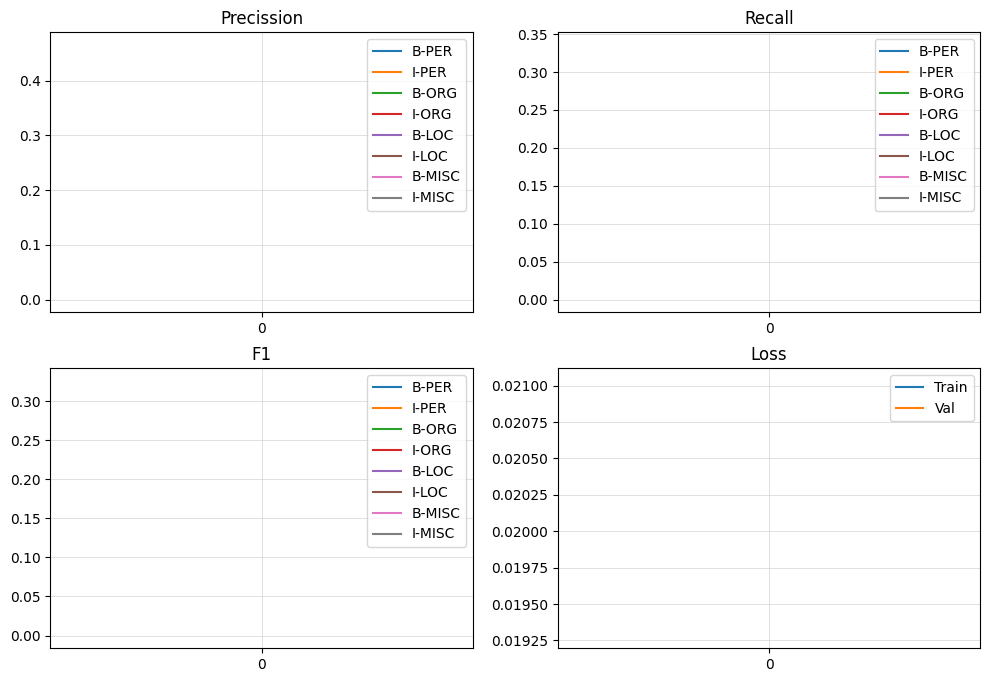

Epoch 1 - Loss: 0.0210 - Val Loss: 0.0193 - Val Prec: 0.1326 - Val Rec: 0.0916 - Val F1: 0.0960


Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0123
Val Prec: [0.79306931 0.71260306 0.56028369 0.38654147 0.60973085 0.
 0.765625   0.        ]
Val Rec: [0.43485342 0.46289212 0.41237882 0.65778961 0.32063146 0.
 0.05314534 0.        ]
Val F1: [0.56171108 0.56122449 0.47508591 0.48693938 0.420264   0.
 0.09939148 0.        ]
support: [1842 1307 1341  751 1837  257  922  346]


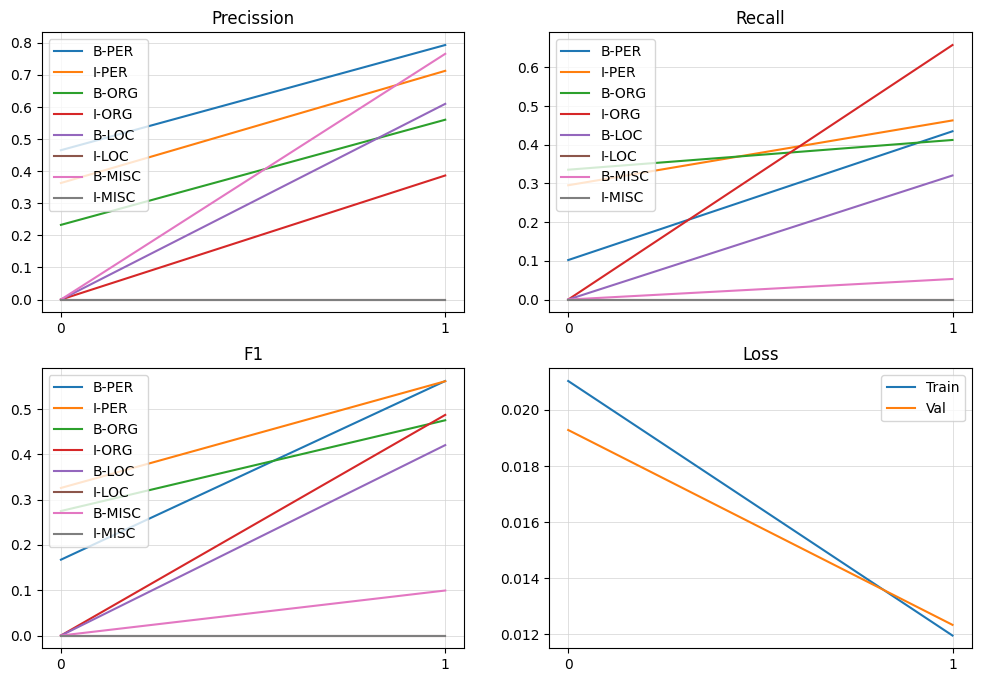

Epoch 2 - Loss: 0.0119 - Val Loss: 0.0123 - Val Prec: 0.4785 - Val Rec: 0.2927 - Val F1: 0.3256


Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0083
Val Prec: [0.63236047 0.58461538 0.69729286 0.59826276 0.8404908  0.83898305
 0.69337979 0.69934641]
Val Rec: [0.67046688 0.72685539 0.63385533 0.73368842 0.59662493 0.38521401
 0.43167028 0.30924855]
Val F1: [0.65085639 0.64802183 0.6640625  0.65909091 0.69786692 0.528
 0.53208556 0.42885772]
support: [1842 1307 1341  751 1837  257  922  346]


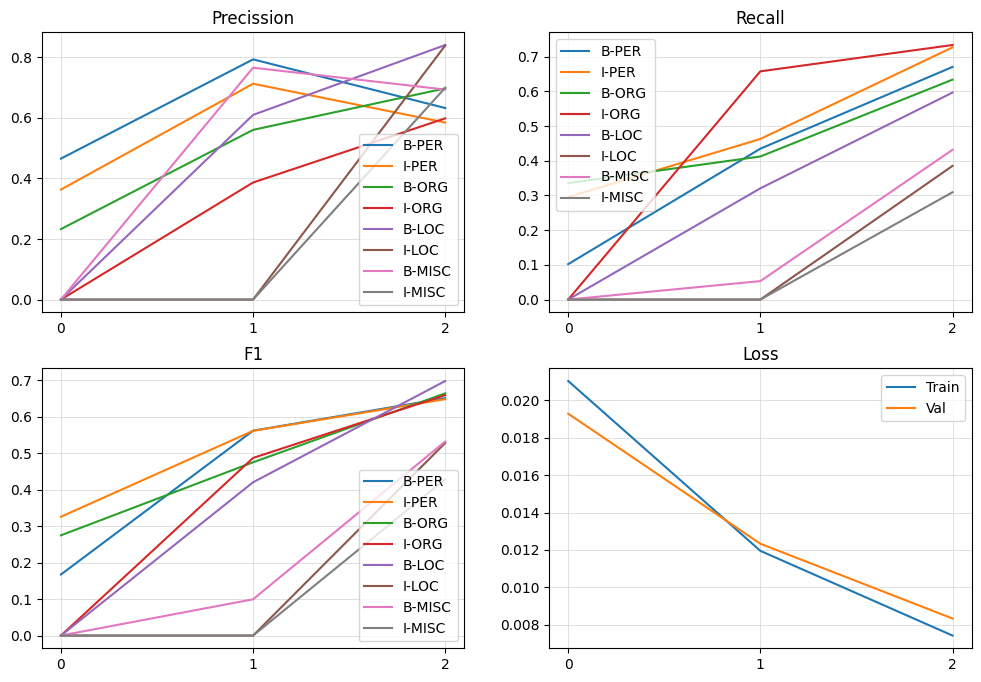

Epoch 3 - Loss: 0.0074 - Val Loss: 0.0083 - Val Prec: 0.6981 - Val Rec: 0.5610 - Val F1: 0.6011


Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0058
Val Prec: [0.85243825 0.75540641 0.84675325 0.62149533 0.81232801 0.67549669
 0.65299685 0.52361396]
Val Rec: [0.73072747 0.77505738 0.72930649 0.88548602 0.80348394 0.79377432
 0.67353579 0.73699422]
Val F1: [0.78690441 0.76510574 0.78365385 0.73036793 0.80788177 0.72987478
 0.66310731 0.6122449 ]
support: [1842 1307 1341  751 1837  257  922  346]


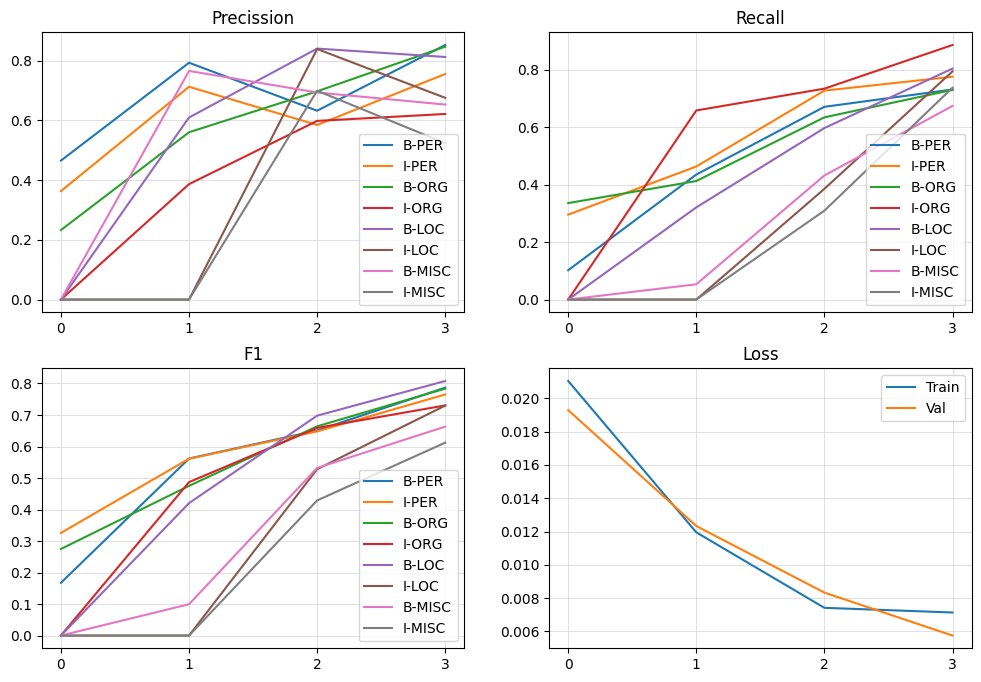

Epoch 4 - Loss: 0.0071 - Val Loss: 0.0058 - Val Prec: 0.7176 - Val Rec: 0.7660 - Val F1: 0.7349


Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0053
Val Prec: [0.83645955 0.8591674  0.80716029 0.73117034 0.84079903 0.64705882
 0.70652174 0.62204724]
Val Rec: [0.77470141 0.74215761 0.73974646 0.84021305 0.75612412 0.81322957
 0.63449024 0.6849711 ]
Val F1: [0.80439684 0.79638752 0.77198444 0.7819083  0.79621668 0.72068966
 0.66857143 0.6519945 ]
support: [1842 1307 1341  751 1837  257  922  346]


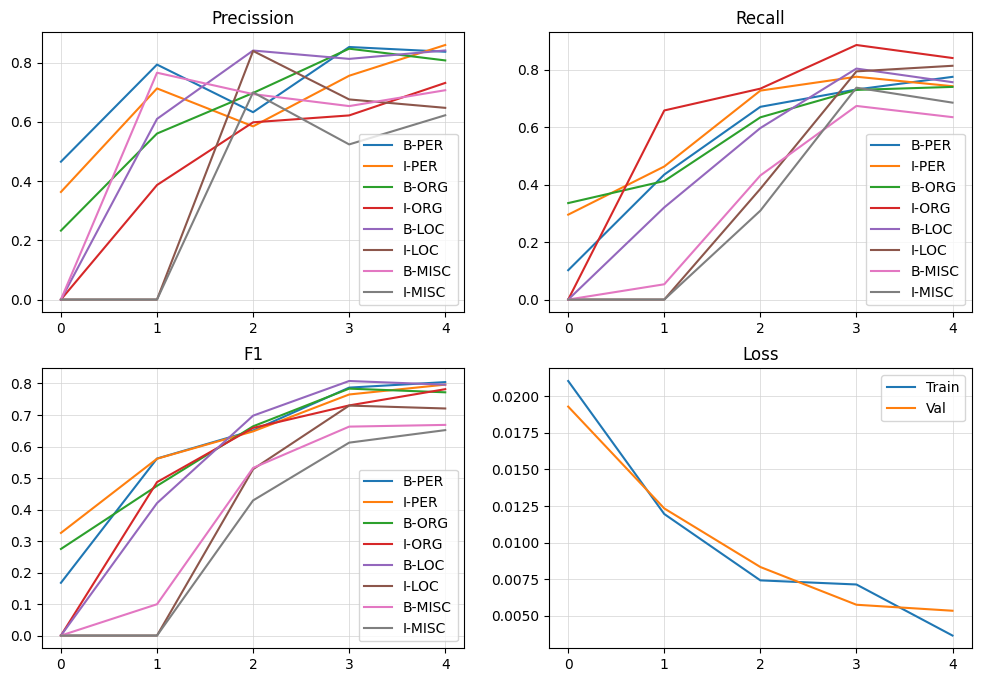

Epoch 5 - Loss: 0.0037 - Val Loss: 0.0053 - Val Prec: 0.7563 - Val Rec: 0.7482 - Val F1: 0.7490


Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0048
Val Prec: [0.86036839 0.72193548 0.89965096 0.74448316 0.84391259 0.60723514
 0.7393675  0.49194991]
Val Rec: [0.78610206 0.85615914 0.76882923 0.85352863 0.88296135 0.91439689
 0.73535792 0.79479769]
Val F1: [0.82156028 0.78333917 0.82911138 0.79528536 0.86299548 0.72981366
 0.73735726 0.60773481]
support: [1842 1307 1341  751 1837  257  922  346]


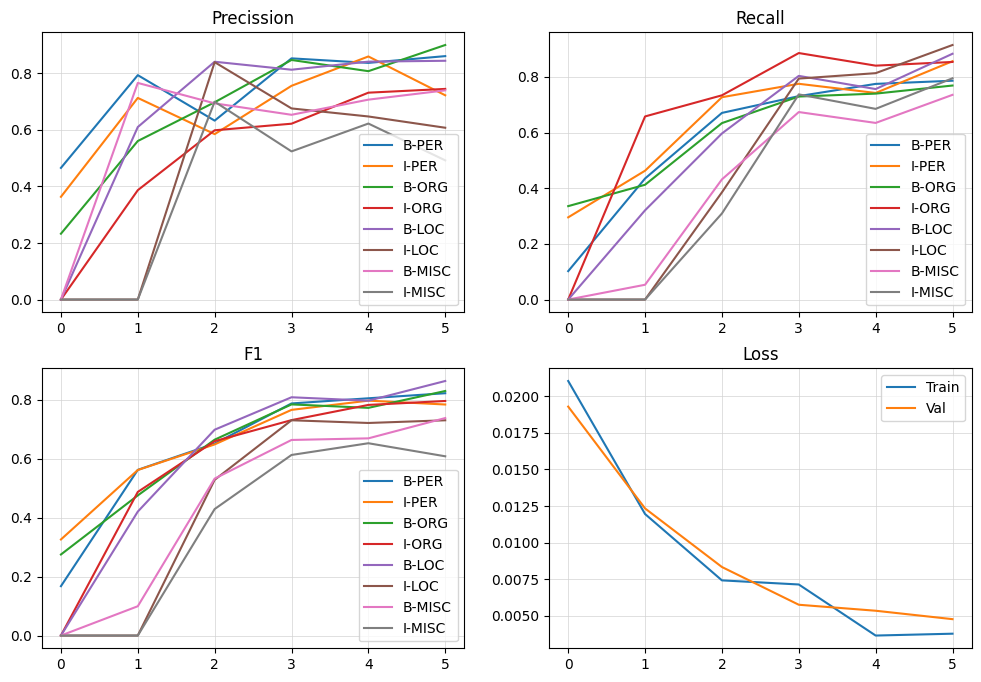

Epoch 6 - Loss: 0.0038 - Val Loss: 0.0048 - Val Prec: 0.7386 - Val Rec: 0.8240 - Val F1: 0.7709


Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0041
Val Prec: [0.84343991 0.7891611  0.84996192 0.83634021 0.87758433 0.78472222
 0.73814433 0.68817204]
Val Rec: [0.83061889 0.81331293 0.83221477 0.86418109 0.87806206 0.87937743
 0.77657267 0.73988439]
Val F1: [0.83698031 0.80105501 0.84099472 0.85003274 0.87782313 0.8293578
 0.75687104 0.71309192]
support: [1842 1307 1341  751 1837  257  922  346]


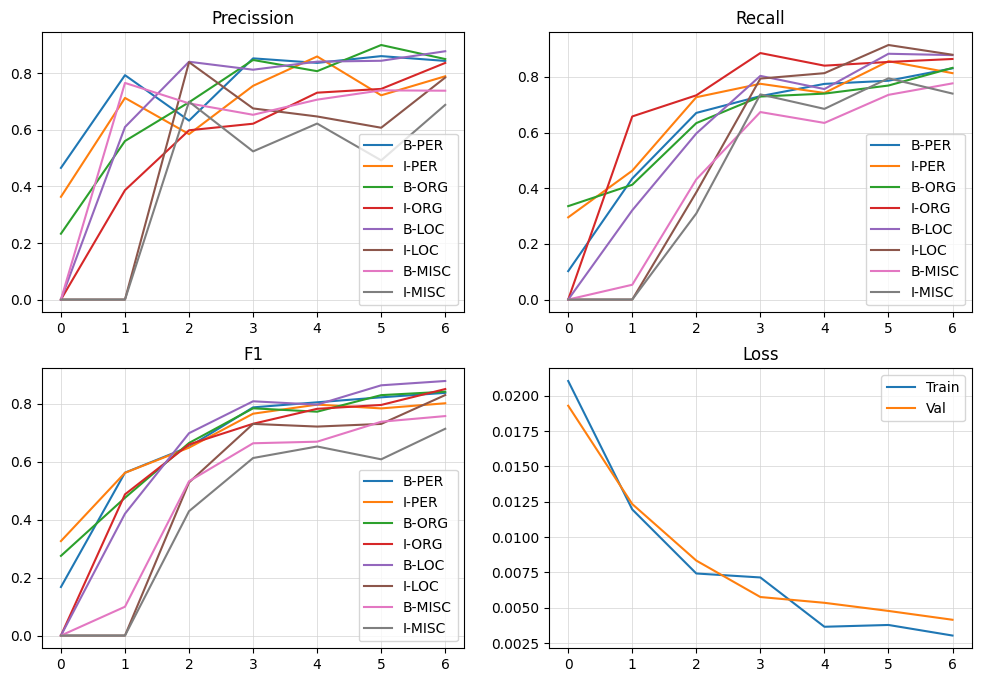

Epoch 7 - Loss: 0.0030 - Val Loss: 0.0041 - Val Prec: 0.8009 - Val Rec: 0.8268 - Val F1: 0.8133


Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0046
Val Prec: [0.83227299 0.7796875  0.84738956 0.81854839 0.91023339 0.80072464
 0.79842932 0.75090253]
Val Rec: [0.78121607 0.76358072 0.78672632 0.81091877 0.8279804  0.85992218
 0.66160521 0.60115607]
Val F1: [0.80593671 0.77155006 0.81593194 0.81471572 0.86716078 0.82926829
 0.72360617 0.66773676]
support: [1842 1307 1341  751 1837  257  922  346]


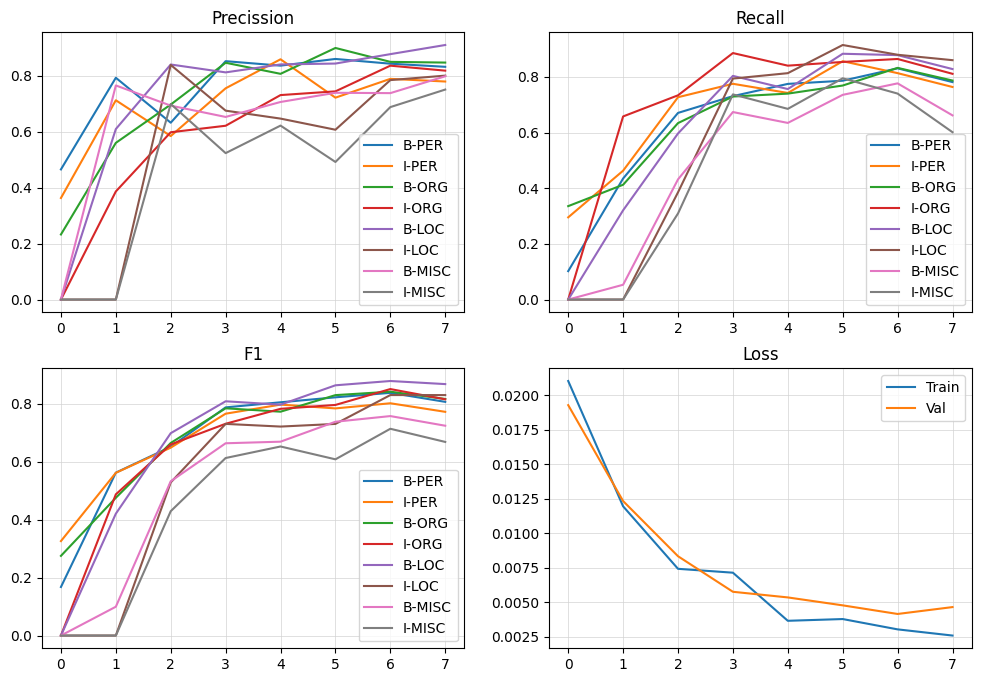

Epoch 8 - Loss: 0.0026 - Val Loss: 0.0046 - Val Prec: 0.8173 - Val Rec: 0.7616 - Val F1: 0.7870


Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0037
Val Prec: [0.8466704  0.85989933 0.88767551 0.84332925 0.92093288 0.80565371
 0.79978118 0.74857143]
Val Rec: [0.82138979 0.78423871 0.84862043 0.91744341 0.88132825 0.88715953
 0.79284165 0.75722543]
Val F1: [0.83383852 0.82032813 0.86770873 0.87882653 0.90069541 0.84444444
 0.7962963  0.75287356]
support: [1842 1307 1341  751 1837  257  922  346]


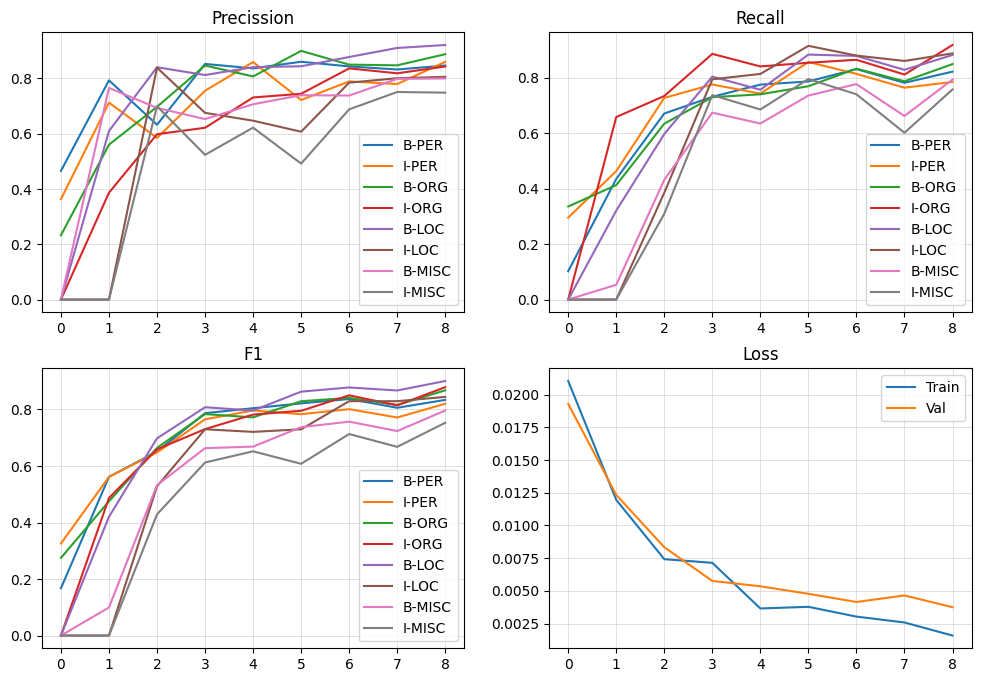

Epoch 9 - Loss: 0.0016 - Val Loss: 0.0037 - Val Prec: 0.8391 - Val Rec: 0.8363 - Val F1: 0.8369


Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0036
Val Prec: [0.80271449 0.88562092 0.8233677  0.83493976 0.90367965 0.89922481
 0.81271283 0.72207084]
Val Rec: [0.8990228  0.82938026 0.89336316 0.92276964 0.90909091 0.90272374
 0.77657267 0.76589595]
Val F1: [0.84814341 0.85657843 0.85693848 0.87666034 0.9063772  0.90097087
 0.79423184 0.74333801]
support: [1842 1307 1341  751 1837  257  922  346]


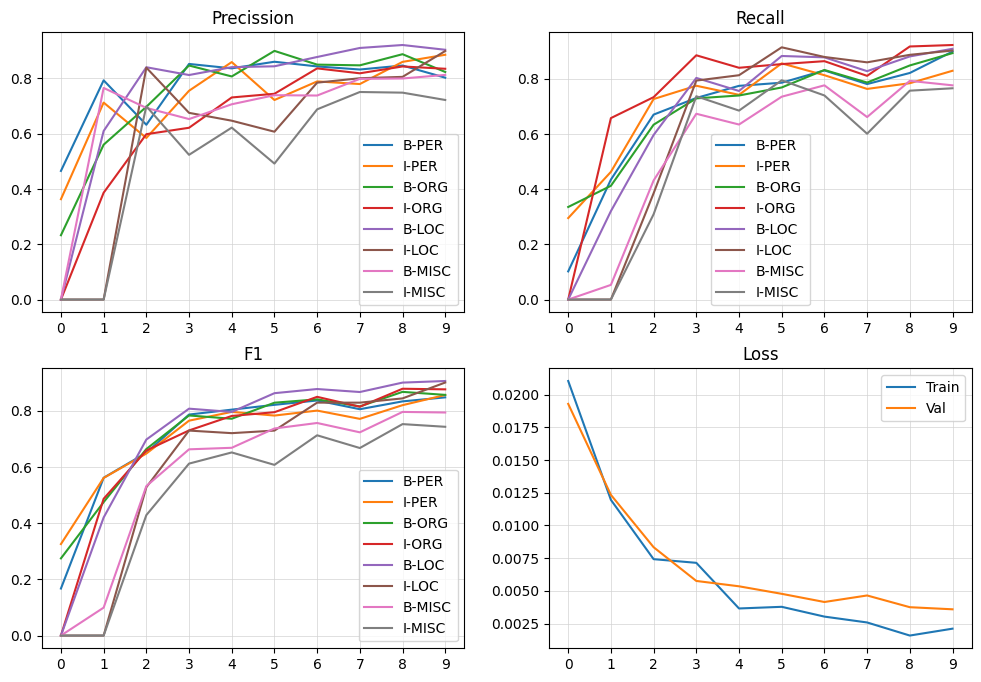

Epoch 10 - Loss: 0.0021 - Val Loss: 0.0036 - Val Prec: 0.8355 - Val Rec: 0.8624 - Val F1: 0.8479


Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0044
Val Prec: [0.90413534 0.83133493 0.75483871 0.75843308 0.91882751 0.83392226
 0.80022447 0.74504249]
Val Rec: [0.78338762 0.79571538 0.87248322 0.92809587 0.88731628 0.91828794
 0.77331887 0.76011561]
Val F1: [0.83944154 0.81313526 0.80940851 0.83473054 0.90279701 0.87407407
 0.78654164 0.75250358]
support: [1842 1307 1341  751 1837  257  922  346]


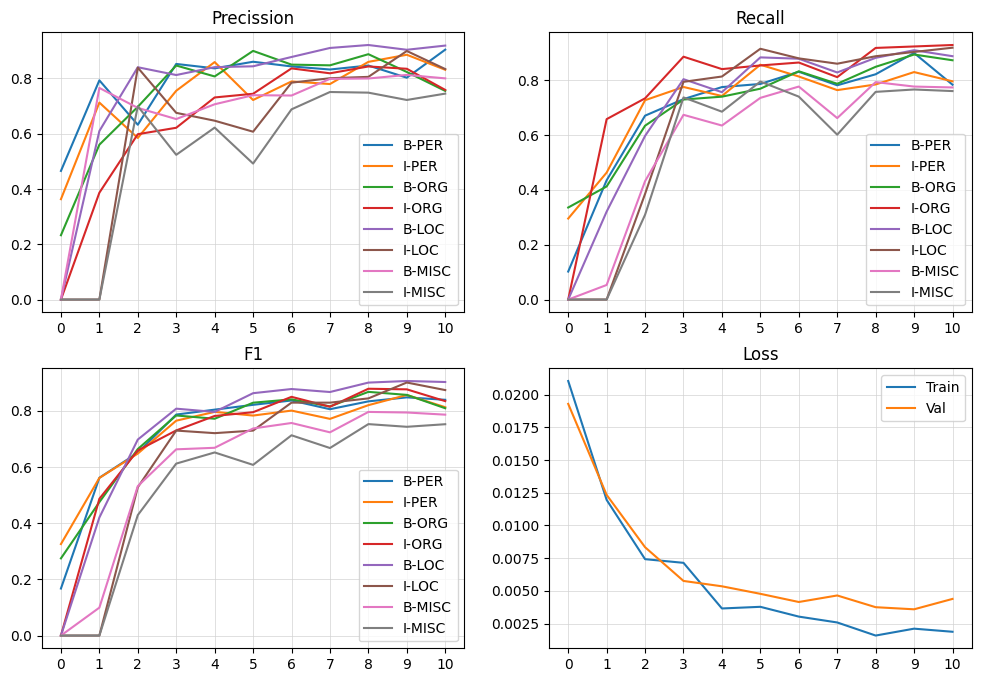

Epoch 11 - Loss: 0.0019 - Val Loss: 0.0044 - Val Prec: 0.8183 - Val Rec: 0.8398 - Val F1: 0.8266


Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0034
Val Prec: [0.89559819 0.84496124 0.89549962 0.92753623 0.93575895 0.87159533
 0.87410072 0.84697509]
Val Rec: [0.86156352 0.83397093 0.87546607 0.85219707 0.89602613 0.87159533
 0.79067245 0.68786127]
Val F1: [0.87825125 0.83943011 0.88536953 0.88827203 0.91546162 0.87159533
 0.83029613 0.75917065]
support: [1842 1307 1341  751 1837  257  922  346]


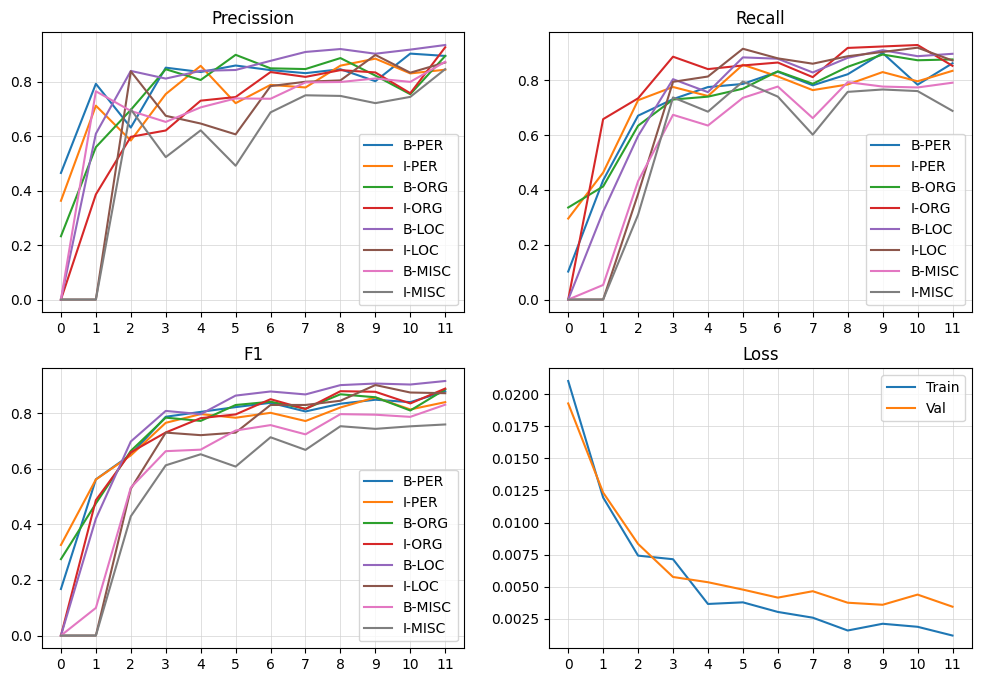

Epoch 12 - Loss: 0.0012 - Val Loss: 0.0034 - Val Prec: 0.8865 - Val Rec: 0.8337 - Val F1: 0.8585


Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0037
Val Prec: [0.88566648 0.8435839  0.87181409 0.87550201 0.91680261 0.82534247
 0.82101977 0.78134111]
Val Rec: [0.86210641 0.85003826 0.86726324 0.87083888 0.91780076 0.93774319
 0.85574837 0.77456647]
Val F1: [0.87372765 0.84679878 0.86953271 0.87316422 0.91730141 0.87795993
 0.83802443 0.77793904]
support: [1842 1307 1341  751 1837  257  922  346]


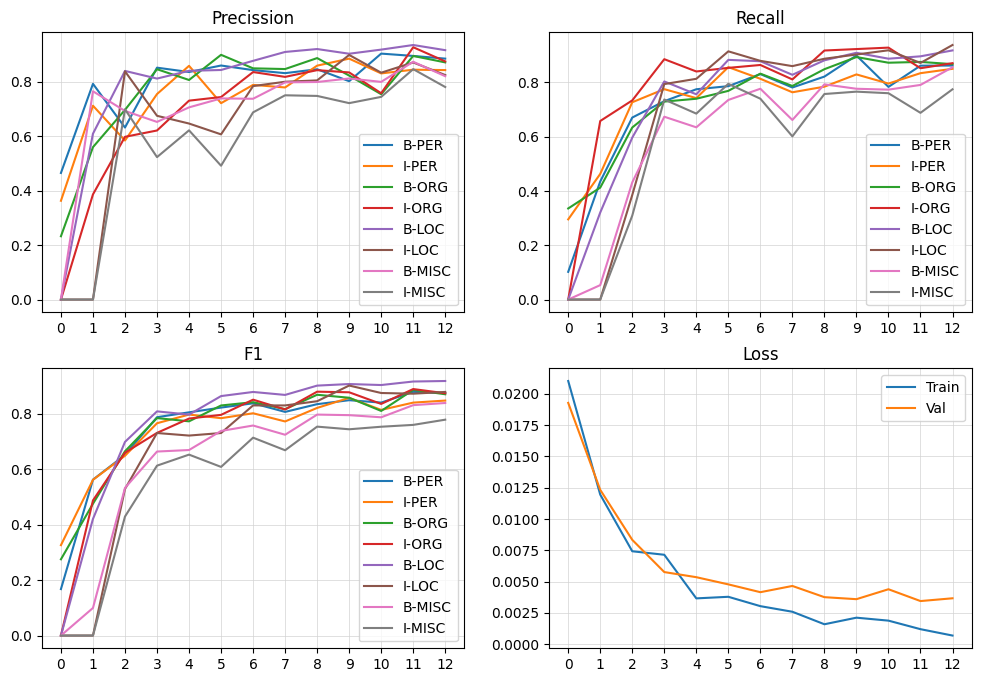

Epoch 13 - Loss: 0.0007 - Val Loss: 0.0037 - Val Prec: 0.8526 - Val Rec: 0.8670 - Val F1: 0.8593


Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0034
Val Prec: [0.88623751 0.85936286 0.89236641 0.90633609 0.91344584 0.86940299
 0.83442266 0.84565916]
Val Rec: [0.8669924  0.8462127  0.87173751 0.87616511 0.91344584 0.90661479
 0.8308026  0.76011561]
Val F1: [0.87650933 0.85273709 0.88193135 0.89099526 0.91344584 0.88761905
 0.8326087  0.80060883]
support: [1842 1307 1341  751 1837  257  922  346]


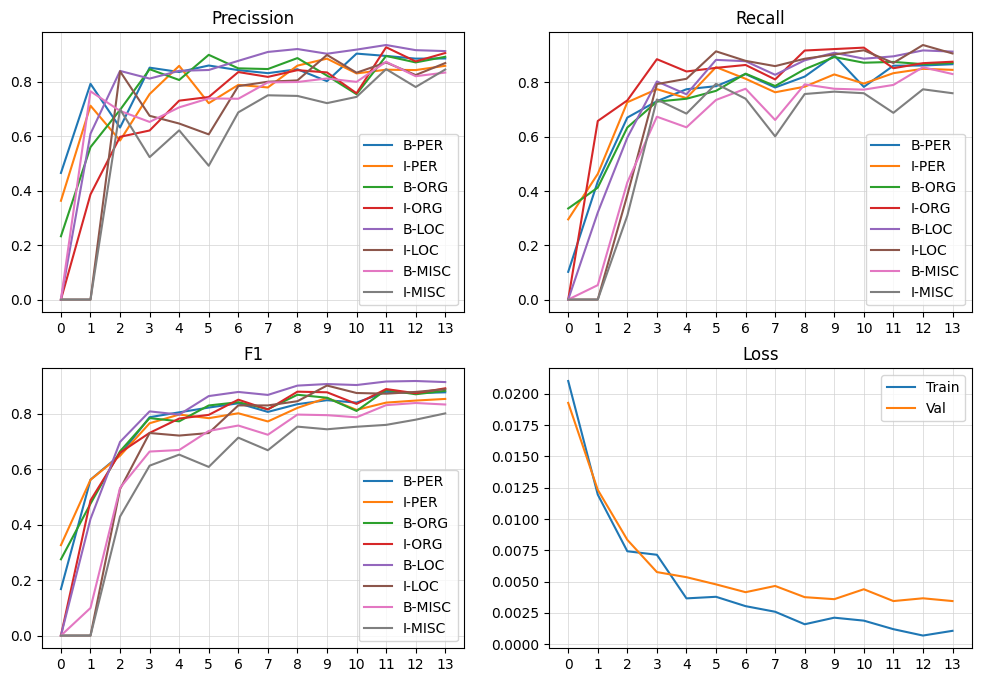

Epoch 14 - Loss: 0.0011 - Val Loss: 0.0034 - Val Prec: 0.8759 - Val Rec: 0.8590 - Val F1: 0.8671


Iteration:   0%|          | 0/1756 [00:00<?, ?it/s]

Validating:   0%|          | 0/407 [00:00<?, ?it/s]

Val Loss: 0.0034
Val Prec: [0.89061632 0.84391337 0.88377358 0.91525424 0.90649065 0.92031873
 0.80848861 0.75966851]
Val Rec: [0.87079262 0.86457536 0.87322893 0.86284953 0.89711486 0.89883268
 0.84707158 0.79479769]
Val F1: [0.88059292 0.85411943 0.87846962 0.88827964 0.90177839 0.90944882
 0.82733051 0.77683616]
support: [1842 1307 1341  751 1837  257  922  346]


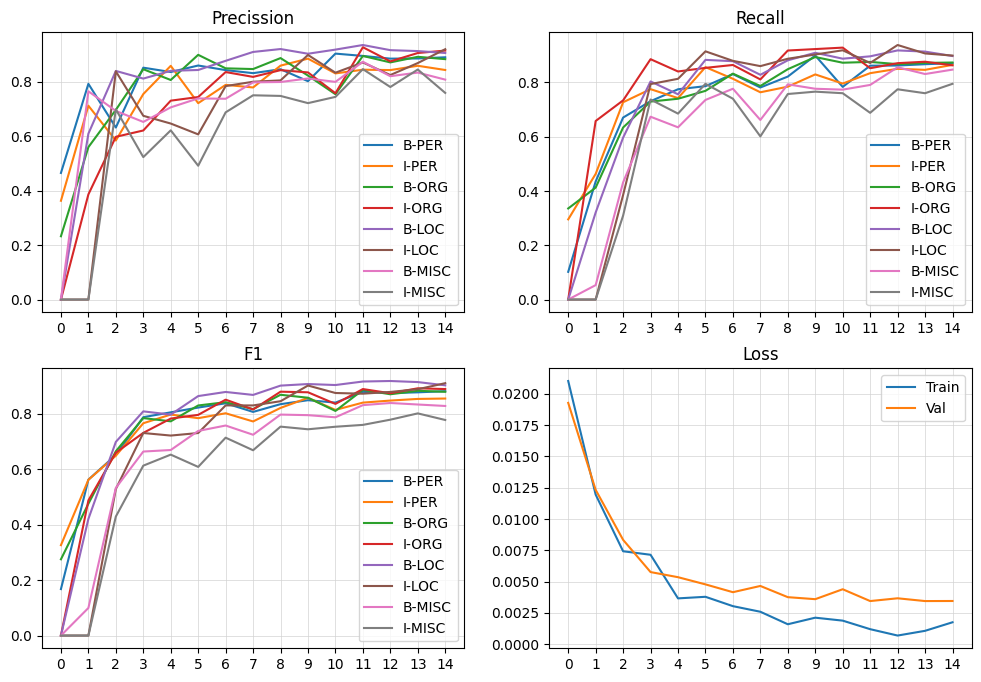

Epoch 15 - Loss: 0.0017 - Val Loss: 0.0034 - Val Prec: 0.8661 - Val Rec: 0.8637 - Val F1: 0.8646


In [27]:
# Do the actual training and validation


train_loss = []
train_batch_loss = []
validation_loss = []
validation_prec = []
validation_rec = []
validation_f1 = []
# iterate through the data 'n_epochs' times
for epoch in tqdmn(range(n_epochs), desc='Epoch'):
    current_loss = 0
    # iterate through each batch of the train data
    for i, batch in enumerate(tqdmn(train_data, desc='Iteration', leave=False)):
        # move the batch tensors to the same device as the 
        batch = { k: v.to(device) for k, v in batch.items() }
        # send 'input_ids', 'attention_mask' and 'labels' to the model
        outputs = model(**batch)
        # the outputs are of shape (loss, logits)
        loss = outputs[0]
        # with the .backward method it calculates all 
        # of  the gradients used for autograd
        loss.backward()
        # NOTE: if we append `loss` (a tensor) we will force the GPU to save
        # the loss into its memory, potentially filling it up. To avoid this
        # we rather store its float value, which can be accessed through the
        # `.item` method
        current_loss += loss.item()

        if i % 8 == 0 and i != 0:
            # update the model using the optimizer
            optimizer.step()
            # once we update the model we set the gradients to zero
            optimizer.zero_grad()
            # store the loss value for visualization
            train_loss.append(current_loss/8)

            current_loss = 0
    # update the model one last time for this epoch
    optimizer.step()
    optimizer.zero_grad()
    train_batch_loss.append(train_loss[-1])

    # calculate accuracy and recall from validation data
    val_loss, val_prec, val_rec, val_f1, support = validate(model, validation_data, device)
    print(f'Val Loss: {val_loss:.4f}\nVal Prec: {val_prec}\nVal Rec: {val_rec}\nVal F1: {val_f1}\nsupport: {support}')
    validation_loss.append(val_loss)
    validation_prec.append(val_prec)
    validation_rec.append(val_rec)
    validation_f1.append(val_f1)
    
    # display grafically the results
    plt.figure(figsize=(12, 8))
    draw_values('Precission', 2, 2, 1, validation_prec, category_texts)
    draw_values('Recall', 2, 2, 2, validation_rec, category_texts)
    draw_values('F1', 2, 2, 3, validation_f1, category_texts)
    draw_values('Loss', 2, 2, 4, list(zip(train_batch_loss, validation_loss)), ['O', 'Train', 'Val'])
    plt.show()

    # print the average results
    print(f'Epoch {epoch + 1} - Loss: {train_loss[-1]:.4f} - Val Loss: {np.mean(val_loss):.4f} - Val Prec: {np.mean(val_prec):.4f} - Val Rec: {np.mean(val_rec):.4f} - Val F1: {np.mean(val_f1):.4f}')


## Visualize the Training Loss

Just visualize the training loss through the iterations.

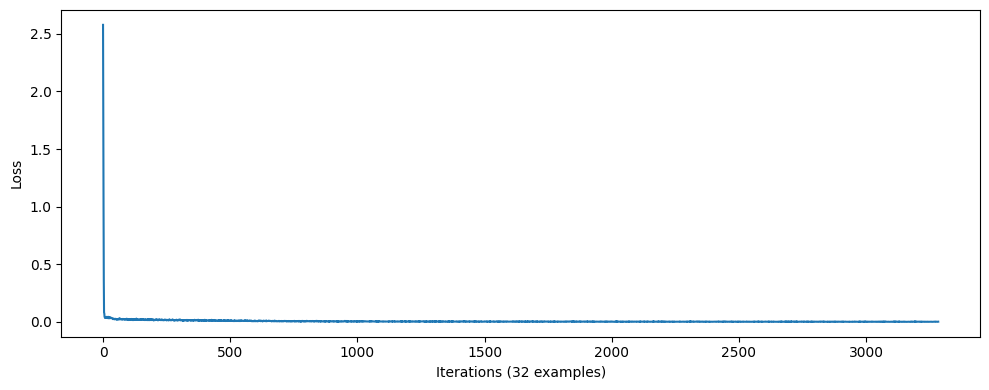

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))
# visualize the loss values
ax.plot(train_loss)
# set the labels
ax.set_ylabel('Loss')
ax.set_xlabel('Iterations (32 examples)')
fig.tight_layout()
plt.show()

# Evaluate the Model

To evaluate the model we must first put it in the `eval` mode. In addition, we must prepare the test dataset in a similar fasion as we did for training. 

In [29]:
model = model.eval()
# batch the train data so that each batch contains 4 examples (using 'batch_size')
test_data = torch.utils.data.DataLoader(dataset['test'], batch_size=4)

The model will be evaluated by creating the confusion matrix. The confusion matrix will show the missmatch between the true labels and the predicted ones. 

First we create a tensor of size (`num_labels`, `num_labels`) in which we will store the results. Then, for each batch in the test dataset we will compare the true label with the predicted one and store it in the confusion matrix.

In [30]:
# create the confusion matrix
confusion = torch.zeros(num_labels, num_labels)

# iterate through each batch of the test data
for i, batch in enumerate(tqdmn(test_data)):
    # do not calculate the gradients
    with torch.no_grad():
        # set the model in 'eval' mode
        model.eval()
        # move the batch tensors to the same device as the model
        batch = { k: v.to(device) for k, v in batch.items() }
        # send 'input_ids', 'attention_mask' and 'labels' to the model
        outputs = model(**batch)
    # get the sentence lengths
    s_lengths = batch['attention_mask'].sum(dim=1)
    # iterate through the examples
    for idx, length in enumerate(s_lengths):
        # get the true values
        true_values = batch['labels'][idx][:length]
        # get the predicted values
        pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
        # go through all true and predicted values and store them in the confusion matrix
        for true, pred in zip(true_values, pred_values):
            confusion[true.item()][pred.item()] += 1

  0%|          | 0/864 [00:00<?, ?it/s]

Now we will normalize the confusion matrix by its rows so that we will see how did the model perform. 

In [31]:
# Normalize by dividing every row by its sum
for i in range(num_labels):
    confusion[i] = confusion[i] / confusion[i].sum()

Visualize the confusion matrix.

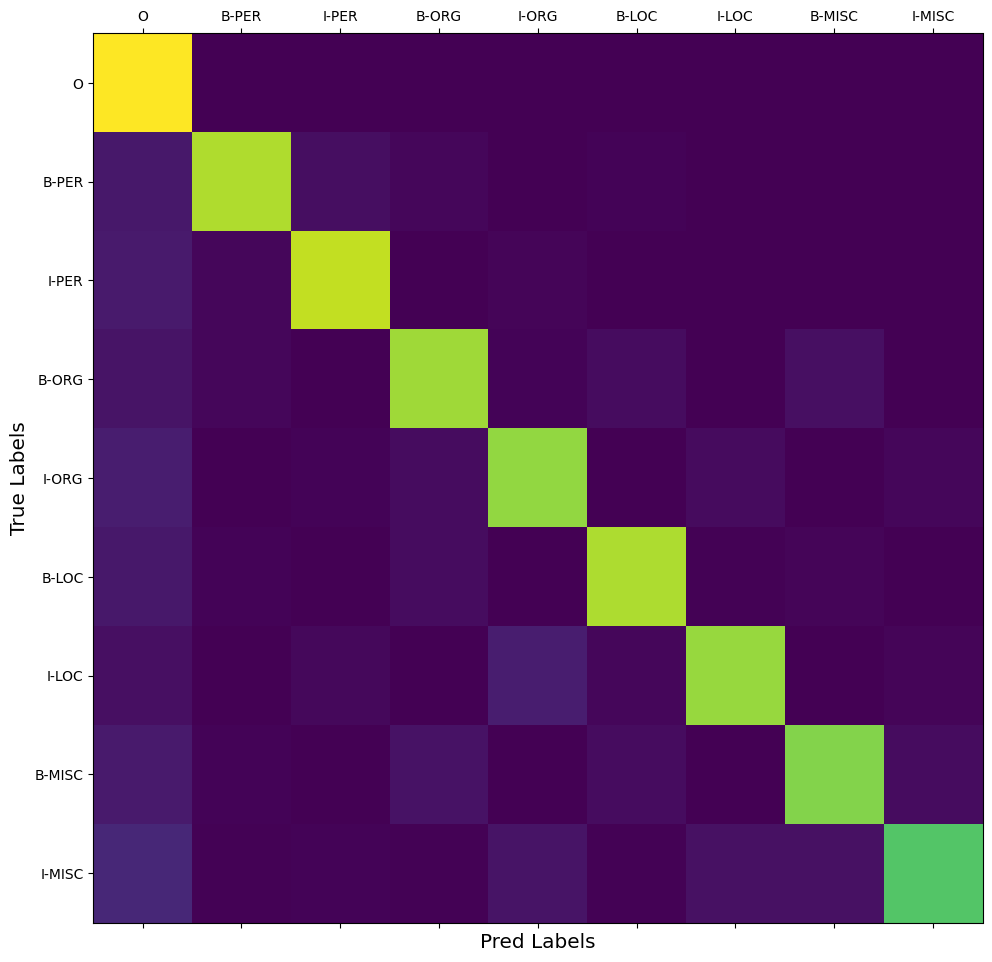

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
# visualize the loss values
ax.matshow(confusion.numpy())

# get the labels
labels = list(label2id.keys())
ids = np.arange(len(labels))

ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')

# set the x ticks
ax.set_xticks(ids)
ax.set_xticklabels(labels)

# set the y ticks
ax.set_yticks(ids)
ax.set_yticklabels(labels)

# plot figure
fig.tight_layout()
plt.show()

In [36]:
test_loss, test_prec, test_rec, test_f1, test_support = validate(model, test_data, device)
print(f'Val Loss: {test_loss:.4f}\nVal Prec: {test_prec}\nVal Rec: {test_rec}\nVal F1: {test_f1}\nsupport: {test_support}')


Validating:   0%|          | 0/864 [00:00<?, ?it/s]

Val Loss: 0.0048
Val Prec: [0.89340102 0.85561056 0.84546001 0.85185185 0.86182251 0.78467153
 0.72657253 0.52525253]
Val Rec: [0.8707483  0.89705882 0.84647803 0.82634731 0.867506   0.83657588
 0.80626781 0.72222222]
Val F1: [0.88192922 0.87584459 0.84596871 0.83890578 0.86465491 0.80979284
 0.76434841 0.60818713]
support: [1617 1156 1661  835 1668  257  702  216]


In [47]:
losses = [validation_loss[-1], test_loss, train_batch_loss[-1]]
precissions = [validation_prec[-1], test_prec]
recalls = [validation_rec[-1], test_rec]
f1s = [validation_f1[-1], test_f1]
support = [support, test_support]

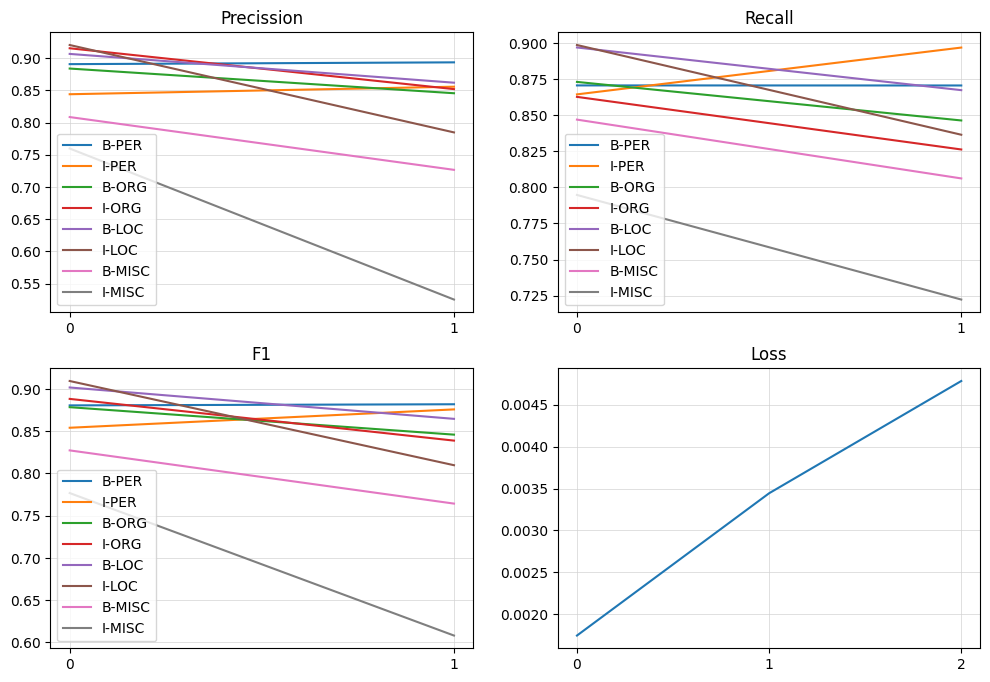

In [46]:
plt.figure(figsize=(12, 8))

draw_values('Precission', 2, 2, 1, precissions, category_texts)
draw_values('Recall', 2, 2, 2, recalls, category_texts)
draw_values('F1', 2, 2, 3, f1s, category_texts)
draw_values('Loss', 2, 2, 4, losses)

plt.show()


In [48]:
model.save_pretrained('models/RobertaNER_connl2003')

In [35]:
# Verify validate() function is consistent with metric function "recall" in evaluate.py

import evaluate

# metric = evaluate.combine(["f1", "precision", "recall"])
metric = evaluate.load("recall")

for batch in tqdmn(mini_data):
    # move the batch tensors to the same device as the 
    batch_input = { k: v.to(device) for k, v in batch.items() }
    # send 'input_ids', 'attention_mask' and 'labels' to the model
    with torch.no_grad():
        outputs = model(**batch_input)
    # get the loss and logits from the output
    loss = outputs.loss
    logits = outputs.logits
    
    # get the predictions by getting the maximum logits value for each token
    predictions = torch.argmax(logits, dim=-1).flatten()
    ground_truth = batch_input['labels'].flatten()
    metric.add_batch(references=ground_truth, predictions=predictions)
results = metric.compute(labels=range(1, num_labels), average=None, zero_division=0)

print(results)

val_loss, val_prec, val_rec, val_f1, support = validate(model, mini_data, device)
print(f'Val Loss: {val_loss:.4f}\nVal Prec: {val_prec}\nVal Rec: {val_rec}\nVal F1: {val_f1}\nsupport: {support}')


  0%|          | 0/10 [00:00<?, ?it/s]

{'recall': array([0.75      , 0.79487179, 0.78461538, 0.23076923, 0.97826087,
       1.        , 0.77777778, 1.        ])}


Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Val Loss: 0.0044
Val Prec: [0.75       0.75609756 0.87931034 1.         0.97826087 1.
 0.53846154 0.42857143]
Val Rec: [0.75       0.79487179 0.78461538 0.23076923 0.97826087 1.
 0.77777778 1.        ]
Val F1: [0.75       0.775      0.82926829 0.375      0.97826087 1.
 0.63636364 0.6       ]
support: [44 39 65 13 46 10  9  3]
